In [70]:
"""
Description:
    Project 2: Naive Bayes Sentiment Analysis (for Digikala and Snappfood reviews)

    Project for Amirkabir University of Technilogy (Tehran Polytechnic), Computer Scince department
    Natural Language Processing course

Student Name & ID: Pouria Alimoradpor 403112088
"""

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

**Data**

In [54]:
datapath = {
    'Digikala': './Datasets/dgkdata.csv',
    'Snappfood': './Datasets/Snappfood - Sentiment Analysis.csv',
}

In [55]:
#Digikala Dataset

data_digikala = pd.read_csv(datapath['Digikala'], encoding='utf-8')
data_digikala.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [56]:
data_digikala.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3261 entries, 0 to 3260
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        3261 non-null   object
 1   Score       3261 non-null   int64 
 2   Suggestion  3261 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 76.6+ KB


In [57]:
data_digikala = data_digikala.drop(columns=['Score'])
data_digikala.rename(columns={'Text': 'review', 'Suggestion': 'label'}, inplace=True)

data_digikala.head()

,review,label
0,این اولین تجربه من برای خرید ایفون هست امروز...,1
1,خرید این محصول رو توصیه میکنم,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,1


In [58]:
# Snappfood Dataset

data_snappfood = pd.read_csv(datapath['Snappfood'], encoding='utf-8', sep='\t+', on_bad_lines='skip', engine='python')
data_snappfood.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [59]:
data_snappfood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   70000 non-null  object
 1   label     70000 non-null  object
 2   label_id  70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [60]:
data_snappfood.drop(columns=['label'], inplace=True)
data_snappfood.rename(columns={'comment': 'review', 'label_id': 'label'}, inplace=True)

data_snappfood.head()

,review,label
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,0
4,شیرینی وانیلی فقط یک مدل بود.,0


In [61]:
# In Digikala dataset, 1 indicates suggesting others to buy 2 means otherwise 3 illustrate a neutral opinion about the product
data_digikala['label'] = data_digikala['label'].replace({1: 1, 2: 0, 3: 0})
# In Snappfood dataset, 1 indicates SAD and 0 indicates HAPPY
data_snappfood['label'] = data_snappfood['label'].replace({1: 0, 0: 1})

In [62]:
# Merge datasets

data = pd.concat([data_digikala, data_snappfood], ignore_index=True)
data = data.sample(frac=1, random_state=4).reset_index(drop=True)

data.to_csv('./Datasets/comnined.csv', index=False, encoding='utf-8')
data.head(20)

,review,label
0,اولین بارم بود سفارش میدادم، واقعا غذاهاتون عا...,1
1,با سلام تشکر می‌کنم از کافه پاین. املت قارچ خو...,1
2,برخلاف سری‌های قبل اصلا تازه نبود و کیفیت خوبی...,0
3,سلاااام، من هات داگ با پنیر گودا، کراکف و چیکن...,1
4,با اینکه تاکید شده بود که بدون کاهووگوجه باشد ...,0
5,ممنونم بابت ارسال سریع. همه چیز خوب بود فقط اگ...,1
6,من از این فروشگاه فوق العاده راضی هستم، علاوه ...,1
7,افتضاح افتضاح خیلی خیلی بد باروژ هر روز بد‌تر ...,0
8,یه مقداری سیب‌زمینی و غذا سرد بود ولی در کل مز...,1
9,همه چی مثل همیشه عالی فقد قیمت‌ها کمی بالاست,1


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73261 entries, 0 to 73260
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  73261 non-null  object
 1   label   73261 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


**Code**

Total data shape: (73261, 2)
Train data shape: (58608, 2)
Test data shape: (14653, 2)


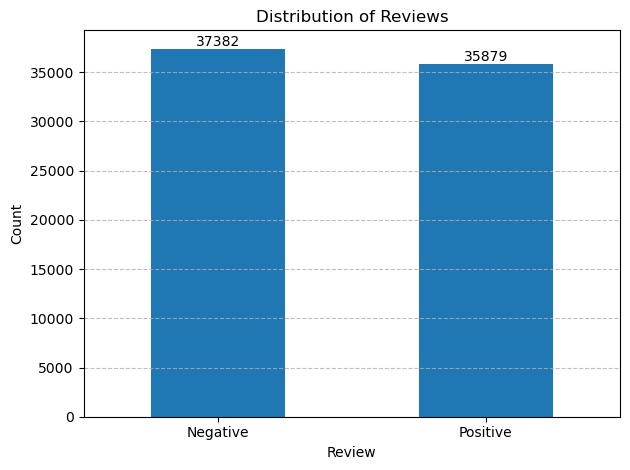

Total tokens: 1473557 — Unique tokens: 53430


In [ ]:
class DataProcessor:
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data file {data_path} not found.")
        self.dataset_path = data_path
    
    def read_data(self, test_size=0.2):
        self.df = pd.read_csv(self.dataset_path).dropna()
        self.train_data, self.test_data = train_test_split(self.df, test_size=test_size, random_state=4, stratify=self.df['label'])
        print(f"Total data shape: {self.df.shape}")
        print(f"Train data shape: {self.train_data.shape}")
        print(f"Test data shape: {self.test_data.shape}")

    def plot_distribution(self):
        self.df['label'].value_counts().plot(kind='bar')
        for i, count in enumerate(self.df['label'].value_counts()):
            plt.text(i, count, str(count), ha='center', va='bottom')
        plt.xlabel('Review')
        plt.ylabel('Count')
        plt.title('Distribution of Reviews')
        plt.xticks([0, 1], ['Negative', 'Positive'], rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.8)
        plt.tight_layout()
        plt.show()
    
    def clean_text(self):
        def clean_raw(text):
            if not isinstance(text, str):
                return ''
            text = re.sub(r'[^آ-ی۰-۹\s]', '', text)
            text = re.sub(r'[a-zA-Z]', '', text)
            text = re.sub(r'[\d]+', 'N', text)
            # text = re.sub(r'[۰-۹0-9]', 'N', text)
            text = re.sub(r'[^\w\s]', '', text)
            # text = re.sub(r'[\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', text)
            return re.sub(r'\s+', ' ', text).strip()
        self.train_data['review'] = self.train_data['review'].apply(clean_raw)
        self.test_data['review'] = self.test_data['review'].apply(clean_raw)

    def count_words(self):
        all_words = ' '.join(self.df['review']).split()
        counts = Counter(all_words)
        self.vocab = dict(counts.most_common())
        with open('frequent.txt', 'w', encoding='utf-8') as f:
            for word, count in list(self.vocab.items())[:200]:
                f.write(f"{word}\t{count}\n")
        print(f"Total tokens: {len(all_words)} — Unique tokens: {len(self.vocab)}")

    def map_word_index(self):
        self.word_to_index = {w: i+1 for i, w in enumerate(self.vocab)}
        self.index_to_word = {i: w for w, i in self.word_to_index.items()}

    def tokenize(self):
        def tokenize_row(row):
            return [self.word_to_index.get(w, 0) for w in row.split()]
        self.train_data['tokens'] = self.train_data['review'].apply(tokenize_row)
        self.test_data['tokens'] = self.test_data['review'].apply(tokenize_row)

        # Save the wordToIndex data
        with open('wordToIndex.txt', 'w', encoding='utf-8') as f:
            for word, index in self.word_to_index.items():
                f.write(f"{word}\t{index}\n")



data_processor = DataProcessor('./Datasets/comnined.csv')
data_processor.read_data()
data_processor.plot_distribution()
data_processor.clean_text()
data_processor.count_words()
data_processor.map_word_index()
data_processor.tokenize()

In [65]:
display(data_processor.train_data.head(10))
display(data_processor.test_data.head(2))

,review,label,tokens
742,کیفیت و بستهبندی بسیار پایین بود,0,"[10, 1, 0, 21, 85, 2]"
21000,ساندویچ الویه هم خیلی خوشمزه بود هم حجمش زیاد ...,1,"[71, 1501, 7, 6, 31, 2, 7, 343, 86, 2, 1, 7, 2..."
6419,عالیییی مرسی فقط برنج مرغوب نیست,1,"[2050, 213, 25, 130, 2038, 105]"
2080,عالی بود عالی بسته بندی فوق العاده طعم غذا عال...,1,"[15, 2, 15, 52, 69, 121, 138, 35, 9, 15, 23, 151]"
50540,طعمش بد نبود اما مزه پنیر پیتزا میداد تا پارمس...,0,"[443, 37, 27, 39, 53, 94, 22, 176, 36, 8345, 1..."
72688,کیک هویج طعمش مثل کیک خونگیه زمان تحویلش هم خی...,1,"[83, 783, 443, 50, 83, 14255, 114, 3350, 7, 6,..."
12902,سلام همه چیش خوبه فقط قدرت زیادی نداره یه وقتا...,0,"[93, 46, 1788, 168, 25, 1273, 312, 201, 32, 11..."
22184,کامل آب شده بود خامه هم معلوم نبود اصلا کیفیتش...,0,"[254, 163, 19, 2, 346, 7, 704, 27, 24, 232, 19..."
44138,پرشین چیکن برگر خیلی خیلی خوشمزه بود ففط برای ...,1,"[13239, 447, 187, 6, 6, 31, 2, 4815, 29, 1809,..."
4191,دم شماگرم مثل همیشه توپ وعالی,1,"[648, 16427, 50, 40, 4981, 3156]"


,review,label,tokens
30709,از نظر کیفیت و مزه قابل قبول و مثل برگرهای خوب...,0,"[5, 110, 10, 1, 53, 117, 441, 1, 50, 5577, 11,..."
3535,همش کاهو خیار بود فقط ردپای رست بیف داشت,0,"[553, 378, 822, 2, 25, 11053, 894, 833, 61]"


In [ ]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_word_counts = defaultdict(Counter)
        self.class_counts = Counter()
        self.class_priors = {}
        self.word_log_probs = defaultdict(dict)

    def count_word_per_class(self, data):
        for tokens, label in zip(data['tokens'], data['label']):
            self.class_counts[label] += 1
            self.class_word_counts[label].update(tokens)

    def calculate_word_log_prob_per_class(self):
        self.vocab_size = len(set(word for c in self.class_word_counts.values() for word in c))
        for c in self.class_counts:
            total_words = sum(self.class_word_counts[c].values())
            for word in range(self.vocab_size + 1):
                count = self.class_word_counts[c][word]
                prob = (count + 1) / (total_words + self.vocab_size)
                self.word_log_probs[c][word] = np.log(prob)

    def calculate_log_prior(self):
        total_samples = sum(self.class_counts.values())
        for c in self.class_counts:
            self.class_priors[c] = np.log(self.class_counts[c] / total_samples)

    def predict_naive_bayes(self, tokens, print_=False):
        scores = {}
        for c in self.class_counts:
            score = self.class_priors[c]
            for word in tokens:
                score += self.word_log_probs[c].get(word, np.log(1 / (sum(self.class_word_counts[c].values()) + self.vocab_size)))
            scores[c] = score
        if print_:
            sentence = ' '.join([data_processor.index_to_word.get(word, '') for word in tokens])
            print(f"Score for sentence: \"{sentence}\":\n{scores}")

        return max(scores, key=scores.get)

    def evaluate(self, data):
        y_true = data['label'].tolist()
        y_pred = [self.predict_naive_bayes(tokens) for tokens in data['tokens']]

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

classifier = NaiveBayesClassifier()
classifier.count_word_per_class(data_processor.train_data)
classifier.calculate_word_log_prob_per_class()
classifier.calculate_log_prior()
classifier.evaluate(data_processor.test_data)

Accuracy: 0.8375076776086808
Precision: 0.8832731648616126
Recall: 0.7853417145914137
F1 Score: 0.831433628318584
Confusion Matrix:
 [[6400  776]
 [1605 5872]]


In [67]:
# Get from the user
test_text = input("Enter a test text: ")
test_tokens = [data_processor.word_to_index.get(word, 0) for word in test_text.split()]
print(f"Tokens for test text: {test_tokens}")
predicted_class = classifier.predict_naive_bayes(test_tokens, print_=True)
print(f"Predicted class for the test text: {'POSITIVE' if predicted_class == 1 else 'NEGATIVE'} ({predicted_class})")

Tokens for test text: [3, 95, 33]
Score for sentence: "به موقع رسید":
{0: -18.179283035818635, 1: -15.608217544485294}
Predicted class for the test text: POSITIVE (1)


In [68]:
good_text = "از این بهتر نمیشه"
bad_text = "از این بدتر نمیشه"
good_tokens = [data_processor.word_to_index.get(word, 0) for word in good_text.split()]
bad_tokens = [data_processor.word_to_index.get(word, 0) for word in bad_text.split()]
print(f"Tokens for good text: {good_tokens}")
print(f"Tokens for bad text: {bad_tokens}")
predicted_class_good = classifier.predict_naive_bayes(good_tokens, print_=True)
predicted_class_bad = classifier.predict_naive_bayes(bad_tokens, print_=True)
print(f"Predicted class for good text: {'POSITIVE' if predicted_class_good == 1 else 'NEGATIVE'} ({predicted_class_good})")
print(f"Predicted class for bad text: {'POSITIVE' if predicted_class_bad == 1 else 'NEGATIVE'} ({predicted_class_bad})")

Tokens for good text: [5, 12, 120, 322]
Tokens for bad text: [5, 12, 976, 322]
Score for sentence: "از این بهتر نمیشه":
{0: -24.28747044425974, 1: -23.610266955755733}
Score for sentence: "از این بدتر نمیشه":
{0: -25.53816087315314, 1: -28.04800419744362}
Predicted class for good text: POSITIVE (1)
Predicted class for bad text: NEGATIVE (0)
